In [17]:
import pandas as pd
from IPython.display import Image
from notebooks.library.display import toggle_input_code
from kid_readout.analysis import resonator, plot_resonator
toggle_input_code()

The metal is 20 nm aluminum. The complex conductivity is what we expect at 250 mK if only thermal quasiparticles are present.
This gives surface resistance $R_s = 3.4 \, \mu \Omega / \square$ and surface reactance $X_s = 0.030 \, \Omega / \square$.

The substrate is silicon with zero conductivity and zero loss tangent.

The simulated resonator is pictured below. It lies on a 5 micron grid, with no bends. The simulation is performed with a minimum subsection of 5 cells (5 microns) with edge meshing. Using edge meshing increases the time per frequency from about 35 minutes to 45 minutes.

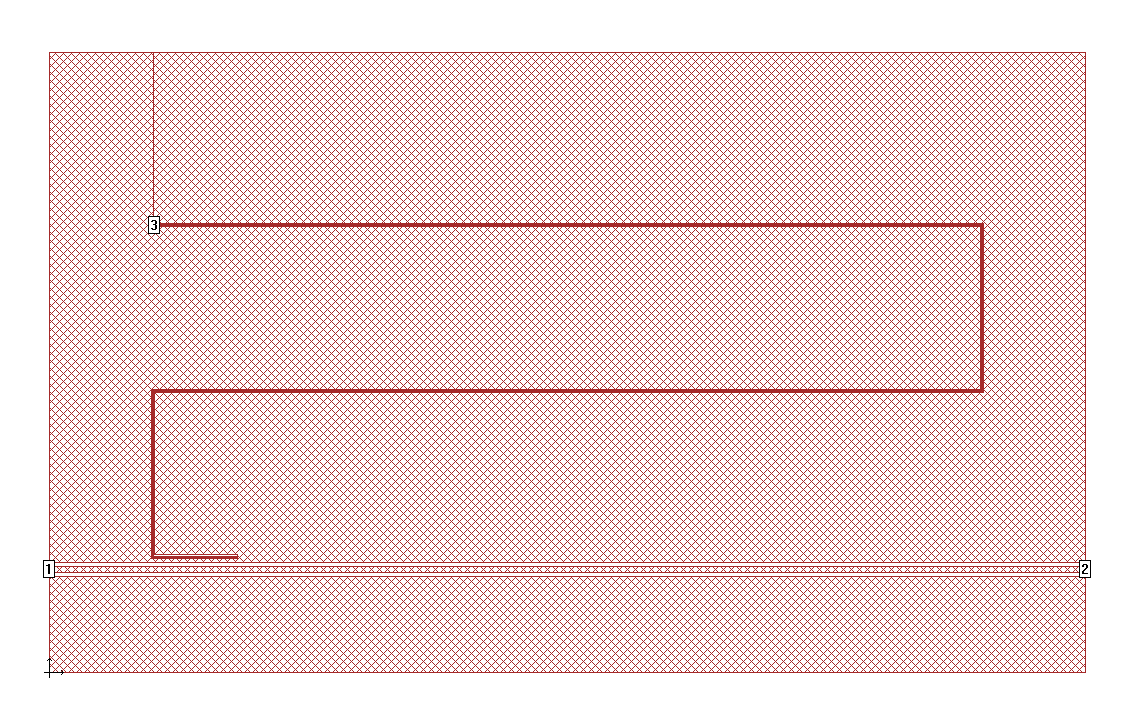

In [2]:
Image(filename='one_manhattan.png') 

To extract the resonance frequency and quality factor in a reasonable amount of time, we use a technique described in Wisbey et al. JLTP (2014): <a href=http://link.springer.com/article/10.1007%2Fs10909-014-1099-3>New Method for Determining the Quality Factor and Resonance Frequency of Superconducting Micro-Resonators from Sonnet Simulations</a>

The technique involves an internal port in the resonator, in this case port 3, at the shorted end. Port 3 has internal resistance $10^{-8} \, \Omega$; previously it was $50 \, \Omega$. This is critical for the resonance from the three-port (input impedance) method to match the resonance from the two-port method.

Near resonance, the input impedance is

$$
Z_{33}(f)
  =
  R [1 + 2 \mathrm{j} Q (f / f_r - 1)].
$$

The resonance frequency is the frequency at which the imaginary part of the input impedance vanishes, and the quality factor can be calculated from the real part and the slope of the imaginary part of the impedance at $f_r$:

\begin{align}
\mathrm{Im} \, Z_{33}(f_r)
  &=
  0; \\
Q
  &=
  \frac{f_r \, \mathrm{d} (\mathrm{Im} \, Z_{33}(f)) / \mathrm{d} f}{2 \mathrm{Re} \, Z_{33}(f_r)}.
\end{align}

In [3]:
z = pd.read_csv('one_manhattan_shorted_zero_0.25K_Z.csv', header=7, delimiter=',')
z['f'] = 1e9 * z.Frequency_GHz

In [4]:
s = pd.read_csv('one_manhattan_shorted_zero_0.25K_S.csv', header=7, delimiter=',')
s['f'] = 1e9 * s.Frequency_GHz

In [5]:
f_original = np.concatenate((np.array([z.f[0]]), np.array(z.f[-3:])))
Z33_original = np.concatenate((np.array([z.REZ33[0] + 1j * z.IMZ33[0]]),
                               np.array(z.REZ33[-3:] + 1j * z.IMZ33[-3:])))

In [6]:
#re_poly = np.polyfit(z.f, z.REZ33, 2)
#im_poly = np.polyfit(z.f, z.IMZ33, 1)
re_poly = np.polyfit(f_original, Z33_original.real, 2)
im_poly = np.polyfit(f_original, Z33_original.imag, 1)

f_r = -im_poly[1] / im_poly[0]
R = np.polyval(re_poly, f_r)
Q = im_poly[0] * f_r / (2 * R)

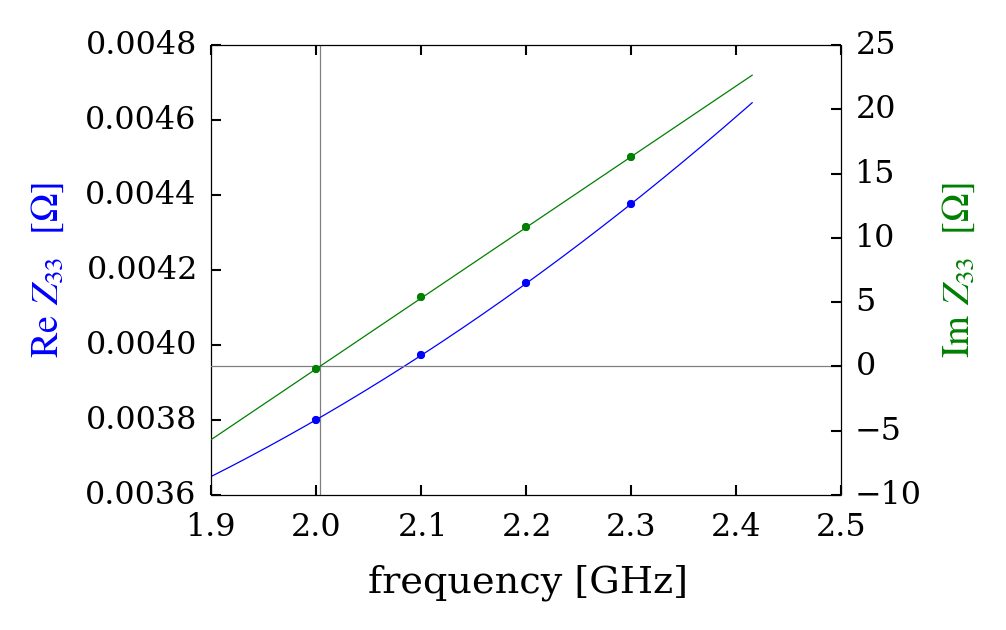

In [7]:
re_color = 'blue'
im_color = 'green'
scale = 1e-9
f_fit = np.linspace(0.95 * z.f.min(), 1.05 * z.f.max(), 1e3)
fig, re_ax = plt.subplots()
im_ax = re_ax.twinx()
im_ax.axhline(0, color='gray')
re_ax.axvline(scale * f_r, color='gray')
re_ax.plot(scale * f_original, Z33_original.real, '.', color=re_color, label='re Z33')
re_ax.plot(scale * f_fit, np.polyval(re_poly, f_fit), color=re_color)
im_ax.plot(scale * f_original, Z33_original.imag, '.', color=im_color, label='im Z33')
im_ax.plot(scale * f_fit, np.polyval(im_poly, f_fit), color=im_color)
re_ax.set_xlabel('frequency [GHz]')
re_ax.set_ylabel(r'$\mathrm{Re} \, Z_{33} \; [\Omega]$', color=re_color)
im_ax.set_ylabel(r'$\mathrm{Im} \, Z_{33} \; [\Omega]$', color=im_color);

As shown in the plot above, we fit a line to $\mathrm{Im} \, Z_{33}$ and a quadratic to $\mathrm{Re} \, Z_{33}$ to determine the parameters. The results are

In [8]:
print("Measured resonance f_r = {:.6f} GHz".format(1e-9 * f_r))
print("Quality factor Q = {:.3g}".format(Q))

Measured resonance f_r = 2.003240 GHz
Quality factor Q = 1.45e+04


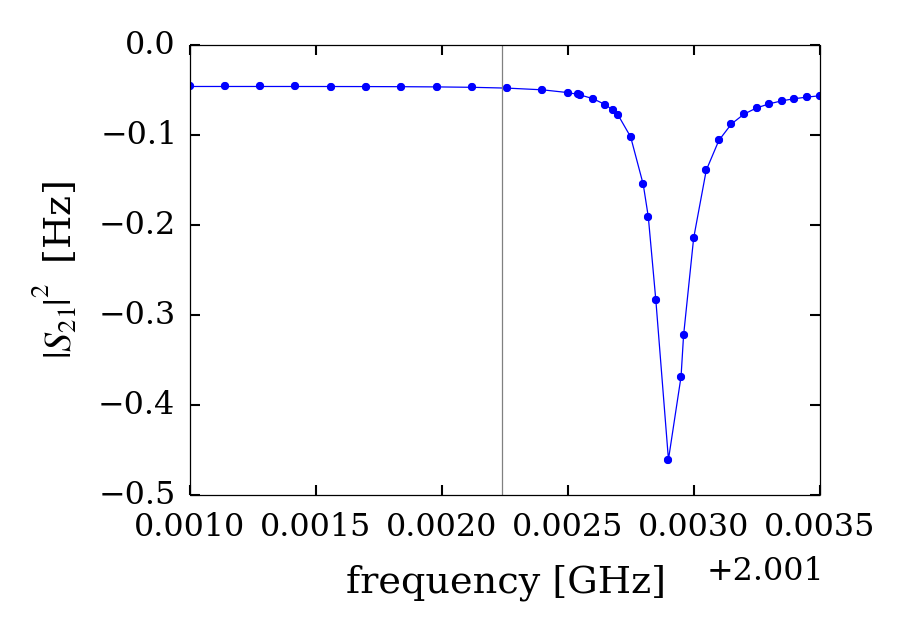

In [9]:
scale = 1e-9
fig, ax = plt.subplots()
ax.plot(scale * s.f, 20 * np.log10(np.abs(s.RES21 + 1j * s.IMS21)), '.-')
#ax.plot(scale * s.f, np.abs(s.RES31 + 1j * s.IMS31), '.')
#ax.plot(scale * s.f, np.abs(s.RES32 + 1j * s.IMS32), '.')
#ax.set_ylim(0.99, 1.0)
ax.set_xlim(2.002, 2.0045)
ax.axvline(scale * f_r, color='gray')
ax.set_ylabel('$|S_{21}|^2$ [Hz]')
ax.set_xlabel('frequency [GHz]');

We take data near the resonance given by the fit and find the resonator in the $S_{21}$ data.

If we ignore the kinetic inductance, the expected resonance based on the resonator length and effective dielectric constant is

In [10]:
from scipy.constants import c
a = 10e-3
epsilon_r = 11.9
epsilon_eff = (1 + epsilon_r) / 2
v = c / epsilon_eff**(1/2)
f_0 = v / (4 * a)
print("Expected resonance f_0 = {:.3f} GHz".format(1e-9 * f_0))

Expected resonance f_0 = 2.951 GHz


Attributing the deviation from this expected value to kinetic inductance gives

In [11]:
alpha = 1 - (f_r / f_0)**2
print("kinetic inductance fraction = {:.2f}".format(alpha))

kinetic inductance fraction = 0.54


The resonator linewidth is

In [12]:
linewidth = f_r / Q
print("linewidth f_r / Q = {:.0f} kHz".format(1e-3 * linewidth))

linewidth f_r / Q = 138 kHz


In [13]:
mask = np.abs(s.f - f_r < 10 * linewidth)
#fig, ax = plt.subplots()
#ax.plot(s[mask].RES21, s[mask].IMS21, '.b')
#ax.plot(s[~mask].RES21, s[~mask].IMS21, '.', color='gray')

If we mask the points that are very far from the resonance, we can use our standard resonator fitting code to fit the Sonnet $S_{21}$ data:

In [14]:
r = resonator.Resonator(np.array(s[mask].f), np.array(s[mask].RES21 + 1j * s[mask].IMS21))

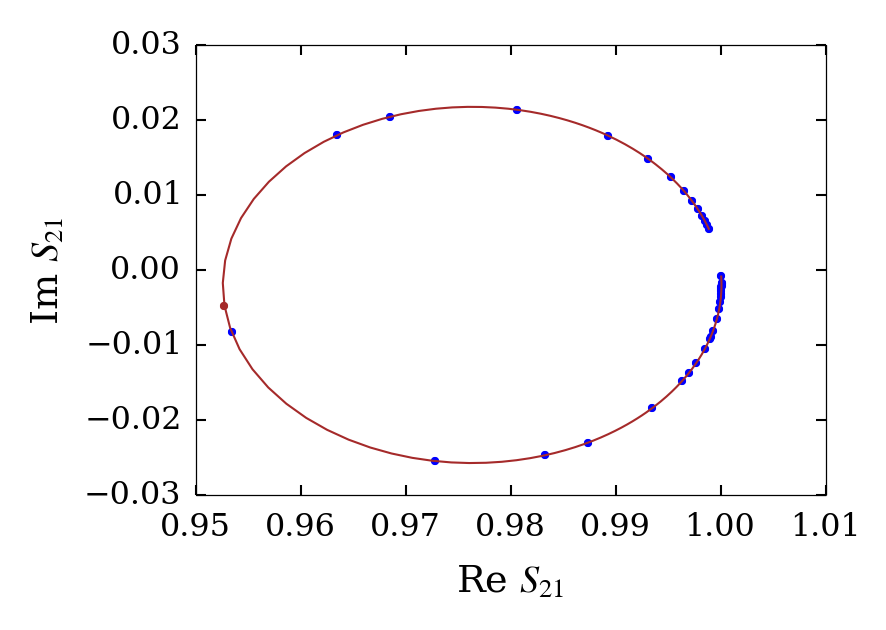

In [15]:
fig = plot_resonator.IQ_circle(r, normalize_s21=True)

The blue dots are the data, the brown line is the fit, and the brown dot is the fit resonance frequency. According to the fit, the resonator parameters are

In [16]:
print("resonance frequency f_r = {:.6f} GHz".format(1e-9 * r.f_0))
print("loaded quality factor Q = {:.0f}".format(r.Q))
print("internal quality factor Q_i = {:.0f}".format(r.Q_i))
print("coupling quality factor Q_c = {:.0f}".format(r.Q_e_real))

resonance frequency f_r = 2.003907 GHz
loaded quality factor Q = 14180
internal quality factor Q_i = 14885
coupling quality factor Q_c = 297524


The internal quality factor is relatively low because the simulation is done at 0.25 K. This design is undercoupled: we want to design for $Q_c = Q_i$ when under the intended optical load. We can easily decrease the coupling quality factor.